**Imports:**

In [1]:
import numpy as np
from types import SimpleNamespace
import time

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from scipy import optimize

# Koopmans-økonomi

w = 13.86


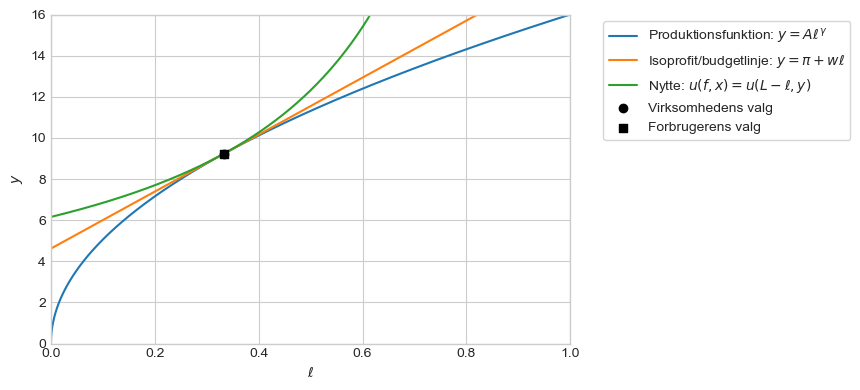

In [2]:
# a. parametere
alpha = 0.5
L = 1
A = 16
gamma = 0.5

# formel for w
w = A*gamma*((alpha+gamma*(1-alpha))/(gamma*(1-alpha)*L))**(1-gamma)
print(f'w = {w:.2f}')

# b. virksomhed
ell = (A*gamma/w)**(1/(1-gamma))
y = A*ell**gamma
pi = (1-gamma)/gamma*w*(A*gamma/w)**(1/(1-gamma))

# c. indkomst
m = w*L + pi

# d. forbruger
f = alpha*m/w
x = (1-alpha)*m

# e. figur
ell_vec = np.linspace(1e-8,L-1e-8,10000)
y_vec = A*ell_vec**gamma
u_i_valg = f**alpha*x**(1-alpha)
indiff_vec = (u_i_valg/(L-ell_vec)**alpha)**(1/(1-alpha))

fig = plt.figure(frameon=False,figsize=(6,6/1.5),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(ell_vec,y_vec,label=r'Produktionsfunktion: $y = A\ell^{\gamma}$')
ax.plot(ell_vec,pi+w*ell_vec,label=r'Isoprofit/budgetlinje: $y = \pi + w\ell$')
ax.plot(ell_vec,indiff_vec,label=r'Nytte: $u(f,x) = u(L-\ell,y)$')
ax.scatter(ell,y,zorder=99,color='black',label=r'Virksomhedens valg')
ax.scatter(L-f,x,zorder=99,marker='s',color='black',label=r'Forbrugerens valg')

# detaljer
ax.set_ylim([0,A*L**gamma])
ax.set_xlim([0,L])
ax.set_xlabel('$\ell$')
ax.set_ylabel('$y$')

fig.tight_layout()
lgd = ax.legend(frameon=True,ncol=1,bbox_to_anchor=(1.05, 1), loc='upper left',)

# Flere forbrugere og virksomheder

In [3]:
np.random.seed(1986) # for at trække tilfældige tal på samme måde hver gang

In [4]:
N = 10 # antal forbrugere
J = 16 # antal virksomheder

# heterogene paramete
alpha_range = [0.1,0.9]
eta_range = [0.5,2.0]
theta_range = [0.0,1.0]
B_range = [2.0,8.0]
gamma_range = [0.1,0.9]

In [5]:
# a. virksomhederne
B_hom = A/J**(1-gamma)*np.ones(J)
B_het = np.random.uniform(*B_range,size=(J,))

gamma_hom = np.repeat(gamma,J)
gamma_het = np.random.uniform(*gamma_range,size=(J,))

# b. præferencer
alpha_hom = np.repeat(alpha,N)
alpha_het = np.random.uniform(*alpha_range,size=(N,))

# c. initialbeholdninger
L_hom = L_het = np.repeat(1/N,N) # tid
e_hom = e_het = np.repeat(0.0,N) # forbrugsvarer

# produktivitet
eta_hom = np.repeat(1.0,N)
eta_het = 1.0 + np.random.uniform(*eta_range,size=(N,))  
    
# ejerandele
theta_hom = np.zeros((J,N))
theta_het = np.zeros((J,N))

for j in range(J):
    
    theta_hom[j,:] = np.repeat(1/N,N)
    
    theta_het[j,:] = np.random.uniform(*theta_range,size=N)
    theta_het[j,:] = theta_het[j,:] / np.sum(theta_het[j,:])
    

Funktion til at tjekke markedsclearing:

In [6]:
def tjek_markedsclearing(w,J,B,gamma,N,L,e,eta,theta,kun_fejl=True):

    # 1. virksomheden
    ell = (gamma*B/w)**(1/(1-gamma))
    y = B*ell**gamma
    pi = y - w*ell
    
    # 2. indkomst
    m = w*eta*L + e
    for j in range(J):
        m += theta[j,:]*pi[j]
        
    # 3. forbrugeren
    f = alpha*m/(eta*w)
    x = (1-alpha)*m
    
    # 4. markedsclearing    
    fejl_ell = np.sum(ell) - np.sum(eta*(L-f))
    fejl_y = np.sum(y) - np.sum(x)
    
    # 5. afslut
    if kun_fejl:
        return fejl_ell
    else:
        print(f'fejl_ell: {fejl_ell:.12f}')
        print(f'fejl_y: {fejl_y:.12f}')
        return ell,y,pi,m,f,x
              

## Homogene forbrugere og virksomheder

In [7]:
fejl = tjek_markedsclearing(w,J,B_hom,gamma_hom,N,L_hom,e_hom,eta_hom,theta_hom)
print(f'fejl = {fejl:.16f}')

fejl = 0.0000000000000004


## Heterogene forbrugere og virksomheder

In [8]:
fejl = tjek_markedsclearing(w,J,B_het,gamma_het,N,L_het,e_het,eta_het,theta_het)
print(f'fejl = {fejl:.16f}')

fejl = -0.0603561772001835


**Find ligevægtspris:**

In [9]:
target = lambda w: tjek_markedsclearing(w,J,B_het,gamma_het,N,L_het,e_hom,eta_het,theta_het)
res = optimize.root_scalar(target,bracket=[w/2,2*w])
w_het = res.root
print(f'w_het = {w_het:.2f}')

w_het = 13.40


Find alle de heterogene valg:

In [10]:
ell_het,y_het,pi_het,m_het,f_het,x_het = tjek_markedsclearing(w_het,J,B_het,gamma_het,N,L_het,e_hom,eta_het,theta_het,kun_fejl=False)

fejl_ell: 0.000000000000
fejl_y: 0.000000000000


**Virksomhederne:**

In [11]:
for j in range(J):
    print(f'virksomhed {j:2d}: B = {B_het[j]:.2f}, gamma = {gamma_het[j]:.2f},  ell = {ell_het[j]:.2f}, y = {ell_het[j]:.2f}, pi = {pi_het[j]:.2f}')

virksomhed  0: B = 5.41, gamma = 0.54,  ell = 0.04, y = 0.04, pi = 0.41
virksomhed  1: B = 2.46, gamma = 0.45,  ell = 0.01, y = 0.01, pi = 0.18
virksomhed  2: B = 5.65, gamma = 0.56,  ell = 0.04, y = 0.04, pi = 0.39
virksomhed  3: B = 7.38, gamma = 0.81,  ell = 0.01, y = 0.01, pi = 0.04
virksomhed  4: B = 5.27, gamma = 0.29,  ell = 0.05, y = 0.05, pi = 1.56
virksomhed  5: B = 6.22, gamma = 0.48,  ell = 0.06, y = 0.06, pi = 0.81
virksomhed  6: B = 4.32, gamma = 0.79,  ell = 0.00, y = 0.00, pi = 0.01
virksomhed  7: B = 5.91, gamma = 0.32,  ell = 0.06, y = 0.06, pi = 1.59
virksomhed  8: B = 6.14, gamma = 0.47,  ell = 0.06, y = 0.06, pi = 0.83
virksomhed  9: B = 6.31, gamma = 0.20,  ell = 0.05, y = 0.05, pi = 2.75
virksomhed 10: B = 6.14, gamma = 0.64,  ell = 0.03, y = 0.03, pi = 0.25
virksomhed 11: B = 6.84, gamma = 0.47,  ell = 0.07, y = 0.07, pi = 1.00
virksomhed 12: B = 3.70, gamma = 0.51,  ell = 0.02, y = 0.02, pi = 0.23
virksomhed 13: B = 6.55, gamma = 0.15,  ell = 0.05, y = 0.05, pi

**Forbrugerne:**

In [12]:
for i in range(N):
    print(f'person {i:2d}:')
    print(f' eta = {eta_het[i]:.2f}, alpha = {alpha_het[i]:.2f}')
    print(f' theta = [',end='')
    for j in range(J):
        print(f' {theta_het[j,i]:.2f}',end='')
    print(f']')
    print(f' m = {m_het[i]:.2f}, f = {f_het[i]:.2f}, x = {x_het[i]:.2f}')
    print('')

person  0:
 eta = 2.86, alpha = 0.51
 theta = [ 0.07 0.15 0.06 0.05 0.15 0.03 0.18 0.06 0.20 0.02 0.08 0.03 0.05 0.14 0.05 0.09]
 m = 5.07, f = 0.07, x = 2.53

person  1:
 eta = 2.50, alpha = 0.12
 theta = [ 0.10 0.14 0.04 0.09 0.03 0.12 0.17 0.08 0.05 0.12 0.08 0.21 0.14 0.14 0.10 0.07]
 m = 4.86, f = 0.07, x = 2.43

person  2:
 eta = 2.38, alpha = 0.78
 theta = [ 0.06 0.15 0.02 0.06 0.06 0.08 0.11 0.13 0.11 0.03 0.04 0.12 0.13 0.02 0.04 0.08]
 m = 4.03, f = 0.06, x = 2.02

person  3:
 eta = 2.04, alpha = 0.88
 theta = [ 0.14 0.10 0.13 0.14 0.16 0.06 0.11 0.11 0.18 0.01 0.13 0.09 0.02 0.02 0.11 0.10]
 m = 3.75, f = 0.07, x = 1.88

person  4:
 eta = 1.79, alpha = 0.22
 theta = [ 0.11 0.02 0.16 0.11 0.16 0.12 0.20 0.11 0.01 0.19 0.08 0.09 0.14 0.16 0.10 0.12]
 m = 4.33, f = 0.09, x = 2.17

person  5:
 eta = 1.70, alpha = 0.63
 theta = [ 0.14 0.12 0.24 0.03 0.04 0.21 0.04 0.12 0.03 0.03 0.14 0.21 0.02 0.14 0.02 0.09]
 m = 3.75, f = 0.08, x = 1.88

person  6:
 eta = 2.20, alpha = 0.77
 th